### Image Filtering and Noise Removal
In this lab, we explore the concepts of image filtering and noise removal techniques. Images often contain noise due to various factors such as sensor limitations, environmental conditions, or transmission errors. Noise can degrade the quality of an image and make it difficult to analyze or process.

#### Objectives:
1. Understand different types of noise, such as salt-and-pepper noise and Gaussian noise.
2. Learn how to add noise to an image programmatically for testing purposes.
3. Explore various filtering techniques to remove noise from images:
	- Mean Filter
	- Median Filter
	- Gaussian Filter
4. Compare the effectiveness of these filters in removing different types of noise.

#### Theory
- **Salt-and-Pepper Noise**: This type of noise appears as random white and black pixels in the image. It is often caused by sharp and sudden disturbances in the image signal.
- **Gaussian Noise**: This noise follows a Gaussian distribution and is often introduced during image acquisition due to electronic circuit noise.
- **Mean Filter**: A simple averaging filter that replaces each pixel value with the mean of its neighboring pixel values.
- **Median Filter**: A non-linear filter that replaces each pixel value with the median of its neighboring pixel values, effective in removing salt-and-pepper noise.
- **Gaussian Filter**: A filter that uses a Gaussian kernel to smooth the image, reducing noise while preserving edges.

By the end of this lab, you will have a better understanding of how to handle noisy images and apply appropriate filtering techniques to enhance image quality.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [36]:
def add_salt_pepper_noise(img: np.ndarray, density: float = 0.02) -> np.ndarray:
    if img is None:
        return
    noisy_img = img.copy()
    height, width = noisy_img.shape[:2]
    num_salt = int(np.ceil(density / 2 * height * width))
    num_pepper = int(np.ceil(density / 2 * height * width))

    for i in range(num_salt):
        randx = np.random.randint(0, height - 1)
        randy = np.random.randint(0, width - 1)
        if noisy_img.ndim >= 3:
            noisy_img[randx, randy, :] = 255
        else:
            noisy_img[randx, randy] = 255

    for i in range(num_pepper):
        randx = np.random.randint(0, height - 1)
        randy = np.random.randint(0, width - 1)
        if noisy_img.ndim >= 3:
            noisy_img[randx, randy, :] = 0
        else:
            noisy_img[randx, randy] = 0
    return noisy_img

In [37]:
def add_gaussian_noise(img: np.ndarray, mean: float = 0, std: float = 10.0) -> np.ndarray:
    if img is None:
        return None

    noisy_img = img.astype(np.float32).copy()

    if img.ndim == 2:
        noise = np.random.normal(mean, std, size=img.shape)
        noisy_img += noise
    elif img.ndim == 3:
        noise = np.random.normal(mean, std, size=img.shape)
        noisy_img += noise

    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

    return noisy_img

In [38]:
def mean_filter(noisy_img: np.ndarray, kernel_size: int = 3):
    if kernel_size % 2 == 0:
        print("Kernel should be odd")
        return
    height, width = noisy_img.shape[:2]
    pad = kernel_size // 2
    img = noisy_img.copy()
    if img.ndim == 3:
        img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="constant")
    else:
        img = np.pad(img, pad, mode="constant")
    channel = 1 if noisy_img.ndim == 2 else 3
    for c in range(channel):
        for y in range(width):
            for x in range(height):
                if noisy_img.ndim == 2:
                    kernel = img[x : x + kernel_size, y : y + kernel_size]
                    img[x + pad, y + pad] = np.mean(kernel)
                else:
                    kernel = img[x : x + kernel_size, y : y + kernel_size, c]
                    img[x + pad, y + pad, c] = np.mean(kernel)
    return img


def median_filter(noisy_img: np.ndarray, kernel_size: int = 3):
    if kernel_size % 2 == 0:
        print("Kernel should be odd")
        return
    height, width = noisy_img.shape[:2]
    pad = kernel_size // 2
    img = noisy_img.copy()
    if img.ndim == 3:
        img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="constant")
    else:
        img = np.pad(img, pad, mode="constant")
    channel = 1 if noisy_img.ndim == 2 else 3
    for c in range(channel):
        for y in range(width):
            for x in range(height):
                if noisy_img.ndim == 2:
                    kernel = img[x : x + kernel_size, y : y + kernel_size]
                    img[x + pad, y + pad] = np.median(kernel)
                else:
                    kernel = img[x : x + kernel_size, y : y + kernel_size, c]
                    img[x + pad, y + pad, c] = np.median(kernel)
    return img


def gaussian_filter(noisy_img: np.ndarray, kernel_size: int = 3, sigma: float = 1.0):
    if kernel_size % 2 == 0:
        print("Kernel should be odd")
        return noisy_img

    pad = kernel_size // 2
    img = noisy_img.copy()
    padding = (
        (
            ((pad, pad), (pad, pad), (0, 0))
            if noisy_img.ndim == 3
            else ((pad, pad), (pad, pad))
        )
        if noisy_img.ndim == 3
        else pad
    )

    padded_img = np.pad(img, padding, mode="constant")
    channel = 1 if noisy_img.ndim == 2 else 3
    filtered_img = noisy_img.copy().astype(np.float32)

    x, y = np.mgrid[
        -(kernel_size // 2) : kernel_size // 2 + 1,
        -(kernel_size // 2) : kernel_size // 2 + 1,
    ]
    gaussian_kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()

    height, width = noisy_img.shape[:2]

    for c in range(channel):
        for y in range(height):
            for x in range(width):
                y_start = y
                y_end = y + kernel_size
                x_start = x
                x_end = x + kernel_size

                if channel == 1:
                    neighbor = padded_img[y_start:y_end, x_start:x_end]
                    filtered_img[y, x] = np.sum(neighbor * gaussian_kernel)
                else:
                    neighbor = padded_img[y_start:y_end, x_start:x_end, c]
                    filtered_img[y, x, c] = np.sum(neighbor * gaussian_kernel)

    return np.clip(filtered_img, 0, 255).astype(np.uint8)

In [39]:
img = cv.imread("./stdimgs/peppers.png", cv.IMREAD_GRAYSCALE)
sp_noisy_img = add_salt_pepper_noise(img, density=0.04)
sp_mean_filtered = mean_filter(sp_noisy_img, kernel_size=3)
sp_median_filtered = median_filter(sp_noisy_img, kernel_size=3)
sp_gaussian_filtered = gaussian_filter(sp_noisy_img, kernel_size=3, sigma=1.0)

gaussian_noisy_img = add_gaussian_noise(img, mean=0, std=20.0)
gaussian_mean_filtered = mean_filter(gaussian_noisy_img, kernel_size=3)
gaussian_median_filtered = median_filter(gaussian_noisy_img, kernel_size=3)
gaussian_gaussian_filtered = gaussian_filter(gaussian_noisy_img, kernel_size=3, sigma=1.0)


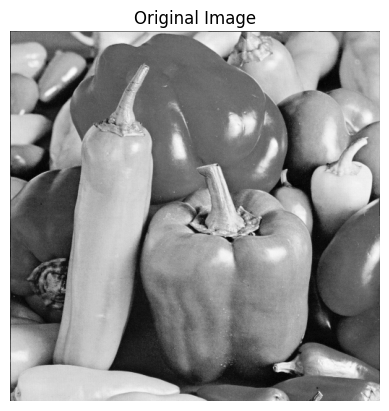

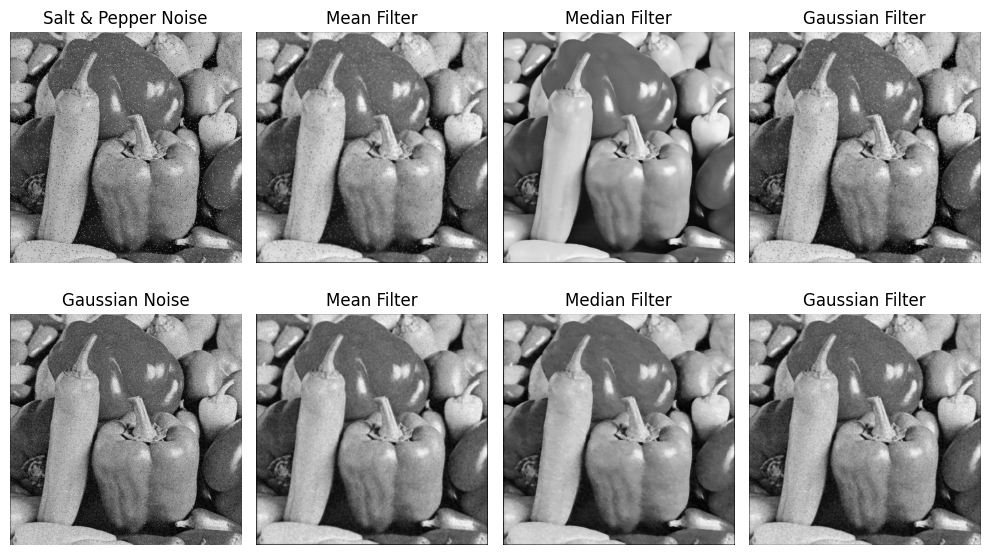

In [40]:
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()


plt.figure(figsize=(10, 6))

plt.subplot(2, 4, 1)
plt.title("Salt & Pepper Noise")
plt.imshow(sp_noisy_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.title("Mean Filter")
plt.imshow(sp_mean_filtered, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 3)
plt.title("Median Filter")
plt.imshow(sp_median_filtered, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.title("Gaussian Filter")
plt.imshow(sp_gaussian_filtered, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.title("Gaussian Noise")
plt.imshow(gaussian_noisy_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.title("Mean Filter")
plt.imshow(gaussian_mean_filtered, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.title("Median Filter")
plt.imshow(gaussian_median_filtered, cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 8)
plt.title("Gaussian Filter")
plt.imshow(gaussian_gaussian_filtered, cmap="gray")
plt.axis("off")

plt.tight_layout()